# Импорты и функции

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import random
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [2]:
def dec2bin(x, n=7):
    """
    creating a binary list of integer non-negative x
    """
    u = 2 ** n - 1
    x = int(x)
    assert x >= 0, 'Input value x must be non-negative'
    assert x <= u, f'Input value x with n = {n} must be less than {u}'
    
    y = []
    if x == 0:
        for i in range(n):
            y.append(0)
    else:
        while x != 1:
            y.append(x % 2)
            x = x // 2
        y.append(x)
        delta = n - len(y)
        for i in range(delta):
            y.append(0)
        y.reverse()
    return y

In [3]:
def get_all_X(n_inputs):
    """
    for given number of variables returns
    all binary combinations of these variables
    """
    X = []
    for i in range(2**n_inputs):
        X += [dec2bin(i, n=n_inputs)]
    X = np.array(X)
    return X

In [4]:
def random_boolfunc(n_inputs):
    """
    for given number of variables returns
    the truth table, where output is random binary vector
    """
    X = get_all_X(n_inputs)
    y = np.random.randint(0, 2, size=(2**n_inputs, 1))
    return X, y
   
def _and(n_inputs=2):
    """
    for given number of variables returns
    the truth table of AND logical gate
    """
    X = get_all_X(n_inputs)
    y = np.append(
        np.zeros(shape=(2 ** n_inputs - 1, 1), dtype=int),
        np.array([[1]]),
        axis=0
    )
    return X, y
    
def _or(n_inputs=2):
    """
    for given number of variables returns
    the truth table of OR logical gate
    """
    X = get_all_X(n_inputs)
    y = np.append(
        np.array([[0]]),
        np.ones(shape=(2 ** n_inputs - 1, 1), dtype=int),
        axis=0
    )
    return X, y

def _xor(n_inputs=2):
    """
    for given number of variables returns
    the truth table of XOR logical gate
    """
    X = get_all_X(n_inputs)
    y = (np.sum(X, axis=1) % 2).reshape(-1, 1)
    return X, y

def get_certain_boolfunc(function_number, n_inputs):
    """
    for given function_number and number of variables returns
    the truth table, where output is binary representation of function_number
    
    NOTE: function_number MUST BE NOT MORE THAN 2^(2^n_inputs)-1
    """
    X = get_all_X(n_inputs)
    try:
        y = np.array(dec2bin(function_number, 2 ** n_inputs)).reshape(-1, 1)
        return X, y
    except AssertionError:
        raise ValueError(f'Given function_number = {function_number} is more than 2 ^ (2 ^ n_inputs) - 1 = {2 ** (2 ** n_inputs) - 1}.')
        

def to_dataframe(X, y):
    """
    for the truth table in form of two arrays 
    X [2 ** n_inputs, n_inputs] and y [2 ** n_inputs, 1]
    combine it to the form of Pandas DataFrame
    """
    data=np.concatenate((X, y), axis=1)
    n_inputs = X.shape[1]
    return pd.DataFrame(data=data, columns=[f'x{i}' for i in range(n_inputs, 0, -1)] + ['y'])

In [5]:
class Neuron(nn.Module):
    def __init__(self, n_inputs, activation=nn.Sigmoid(), init_form='normal'):
        super().__init__()
        self.fc = nn.Linear(n_inputs, 1)
        self.activation = activation
        self.init_form = init_form
        if init_form is not None:
            self.init()
    
    def forward(self, x):
        x = self.fc(x)
        x = self.activation(x)
        return x
    
    def init(self):
        if self.init_form == 'normal':
            nn.init.xavier_normal_(self.fc.weight, gain=nn.init.calculate_gain('sigmoid'))
            nn.init.zeros_(self.fc.bias)
        elif self.init_form == 'uniform':
            nn.init.xavier_uniform_(self.fc.weight, gain=nn.init.calculate_gain('sigmoid'))
            nn.init.zeros_(self.fc.bias)
        else:
            print('incorrect init_form')

In [6]:
from copy import deepcopy

# https://github.com/pytorch/pytorch/issues/36459#:~:text=Here%27s%20my%20definition%3A

class BigModel(nn.Module):
    def __init__(self, base_models : list, activation=nn.Sigmoid(), init_form='normal'):
        super().__init__()
        self.base_models = nn.ModuleList(deepcopy(base_models))
        
        # for model in self.base_models:
        #     for param in model.parameters():
        #         param.requires_grad = False
        
        self.n_hidden = len(base_models)
        self.fc = nn.Linear(self.n_hidden, 1)
        self.activation = activation
        self.merge = lambda x: torch.cat(x, dim=1)
        self.init_form = init_form
        if init_form is not None:
            self.init()
    
    def forward(self, x):
        hidden_out = self.merge([module(x) for module in self.base_models])
        out = self.activation(self.fc(hidden_out))
        
        return out
    
    def init(self):
        if self.init_form == 'normal':
            nn.init.xavier_normal_(self.fc.weight, gain=nn.init.calculate_gain('sigmoid'))
            nn.init.zeros_(self.fc.bias)
        elif self.init_form == 'uniform':
            nn.init.xavier_uniform_(self.fc.weight, gain=nn.init.calculate_gain('sigmoid'))
            nn.init.zeros_(self.fc.bias)
        else:
            print('incorrect init_form')

In [7]:
def step(x):
    return torch.heaviside(x - 0.5, torch.tensor([[1.]]))

def check(model, X, y, device, verbose=True):
    out = model(X.to(device))
    step_out = step(out.to('cpu'))
    mask = (step_out != y)[:,0]  
    
    if any(mask):
        wrong_ans_numbers = [i for i in range(mask.shape[0]) if mask[i].item()]
        if verbose:
            print(f'{type(model).__name__} gives wrong answers for samples {wrong_ans_numbers}')
        return X[mask], y[mask]
    else:
        if verbose:
            print('Success!')
        return (None, None)

def train(model, X, y, epochs, device, optimizer='Adam', 
          criterion=torch.nn.BCELoss(), verbose=True, early_stopping=True):
    
    len_dataset = X.shape[0]
    dataset = torch.utils.data.TensorDataset(X, y)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=len_dataset, shuffle=True)
    
    if optimizer=='Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
    else:
        print('other optimizers aren\'t supported yet')
    
    break_flag = False
    log_epoch = epochs // 10
    history_loss = []
    for i in range(1, epochs + 1):
        epoch_loss = 0
        for batch in dataloader:
            X, y = batch
            optimizer.zero_grad()
            output = model(X.to(device))
            loss = criterion(output, y.to(device))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.detach().cpu().item()
            
            if early_stopping:
                step_out = step(output.detach().cpu())
                if all((step_out == y)[:,0]):
                    break_flag = True
                    break
                                
        epoch_loss /= len(dataloader)
        history_loss.append(epoch_loss)
        if verbose and i % log_epoch == 0:
            print(f'epoch {i}: loss {epoch_loss:.2f}')
        if break_flag:
            if verbose:
                print(f'Early stopping at epoch {i}. Network is done.')
            break
        
    return history_loss

def plot_loss(history_loss):
    sns.set_style('darkgrid')
    plt.figure(figsize=(7, 5), dpi=100)
    plt.plot(range(1, len(history_loss) + 1), history_loss)
    plt.ylim(-0.01, max(history_loss)+0.05)
    plt.xlabel('epochs')
    plt.ylabel('train loss')
    plt.show()

# XOR(2)

In [8]:
%%time

n = 2
X, y = _xor(2)
to_dataframe(X, y)

CPU times: user 273 µs, sys: 133 µs, total: 406 µs
Wall time: 404 µs


,x2,x1,y
0,0,0,0
1,0,1,1
2,1,0,1
3,1,1,0


In [9]:
X, y = torch.Tensor(X), torch.Tensor(y)

## Базовый нейрон 1

epoch 500: loss 0.69
epoch 1000: loss 0.69
epoch 1500: loss 0.69
epoch 2000: loss 0.69
epoch 2500: loss 0.69
epoch 3000: loss 0.69
epoch 3500: loss 0.69
epoch 4000: loss 0.69
epoch 4500: loss 0.69
epoch 5000: loss 0.69


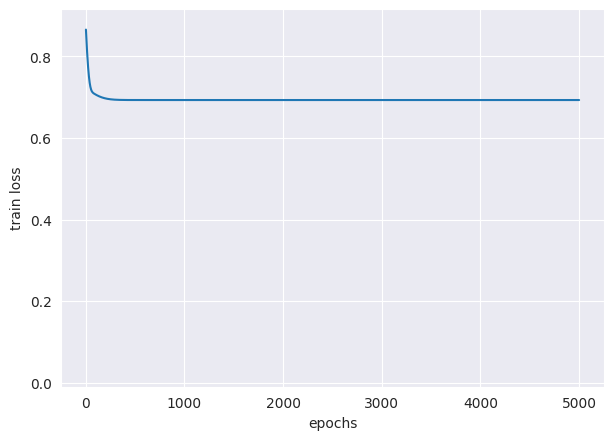

In [10]:
set_random_seed(42)
neuron_1 = Neuron(n_inputs=n).to(device)

h_1 = train(neuron_1, X, y, device=device, epochs=5000, early_stopping=True)
plot_loss(h_1)

In [11]:
X_new, y_new = check(neuron_1, X, y, device=device)

Neuron gives wrong answers for samples [0, 3]


## Базовый нейрон 2

Early stopping at epoch 2. Network is done.


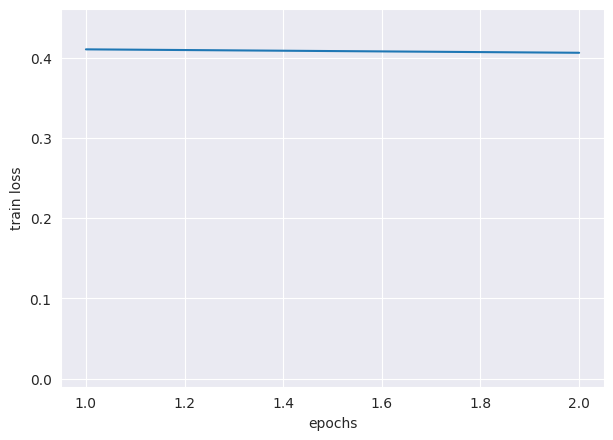

In [12]:
set_random_seed(42)
neuron_2 = Neuron(n_inputs=n).to(device)

h_2 = train(neuron_2, X_new, y_new, device=device, epochs=5000, early_stopping=True)
plot_loss(h_2)

In [13]:
X_new2, y_new2 = check(neuron_2, X_new, y_new, device=device)

Success!


## Большая модель

In [14]:
big_model = BigModel([neuron_1, neuron_2]).to(device)

big_h = train(big_model, X, y, device=device, epochs=5000)

Early stopping at epoch 344. Network is done.


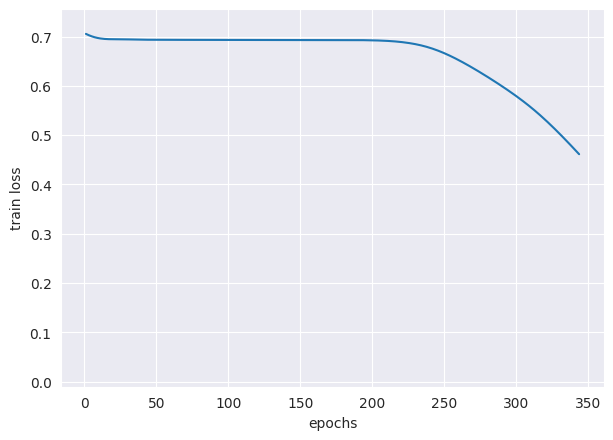

In [15]:
plot_loss(big_h)

In [16]:
check(big_model, X, y, device=device)

Success!


(None, None)

In [17]:
%%time
set_random_seed(42)
history_dict = {}

for i in tqdm(range(100)):
    
    big_model = BigModel([neuron_1, neuron_2]).to(device)

    history = train(big_model, X, y, device=device, epochs=5000, verbose=False)
    
    result = {'history_loss': history}
    result['history_len'] = len(history)
    
    if check(big_model, X, y, device=device, verbose=False)[0] is None:
        result['success'] = True
    else:
        result['success'] = False
    
    history_dict[i+1] = result

100%|█████████████████████████████████████████| 100/100 [01:07<00:00,  1.49it/s]

CPU times: user 1min 7s, sys: 41.7 ms, total: 1min 7s
Wall time: 1min 7s


In [18]:
run_df = pd.DataFrame(history_dict).T.astype(dict(zip(history_dict[1].keys(), ['object', 'int', 'bool'])))
counter = run_df['success'].value_counts().to_dict()
run_df

,history_loss,history_len,success
1,"[0.747025728225708, 0.7425018548965454, 0.7381...",397,True
2,"[0.7063231468200684, 0.705280065536499, 0.7043...",239,True
3,"[0.6886317729949951, 0.6875832080841064, 0.686...",165,True
4,"[0.6972475051879883, 0.6962710618972778, 0.695...",195,True
5,"[0.7132344841957092, 0.7113872766494751, 0.709...",302,True
...,...,...,...
96,"[0.7237498760223389, 0.7202456593513489, 0.716...",303,True
97,"[0.7728310823440552, 0.7687989473342896, 0.764...",312,True
98,"[0.6899600028991699, 0.6889079809188843, 0.687...",170,True
99,"[0.9841620922088623, 0.9738593101501465, 0.963...",366,True


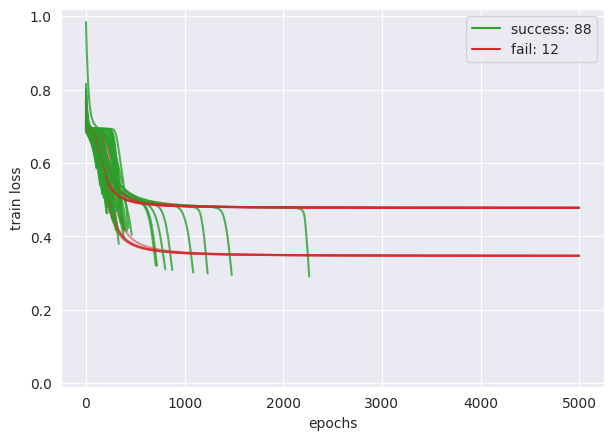

In [19]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='tab:green', label=f"success: {counter[True]}"),
                   Line2D([0], [0], color='tab:red', label=f"fail: {counter[False]}")]


plt.figure(figsize=(7, 5), dpi=100)
for i in history_dict:
    color = 'tab:green' if history_dict[i]['success'] else 'tab:red'
    alpha = 0.8 if history_dict[i]['success'] else 0.5
    plt.plot(history_dict[i]['history_loss'], color=color, alpha=alpha)
plt.legend(handles=legend_elements)
plt.ylim(-0.01)
plt.xlabel('epochs')
plt.ylabel('train loss')
plt.show()

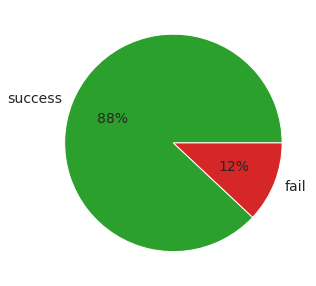

In [20]:
plt.figure(figsize=(5,5))
plt.pie(counter.values(), 
        labels=list(map(lambda x: 'success' if x else 'fail', counter.keys())),
        colors=['tab:green', 'tab:red'],
        autopct='%.0f%%',
        textprops={'fontsize': 14})
plt.show()

In [21]:
stat_big = run_df[run_df['success']]['history_len'].describe()
stat_big

count      88.000000
mean      335.920455
std       308.500013
min       108.000000
25%       193.000000
50%       266.000000
75%       335.000000
max      2264.000000
Name: history_len, dtype: float64

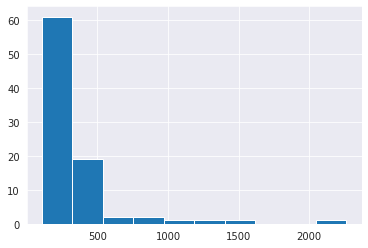

In [22]:
run_df[run_df['success']]['history_len'].hist();

## MLP 2-2-1

In [23]:
%%time
set_random_seed(42)
history_dict = {}

for i in tqdm(range(100)):
    
    mlp = nn.Sequential(
        nn.Linear(n,2),
        nn.Sigmoid(),
        nn.Linear(2,1),
        nn.Sigmoid()
    ).to(device)
    
    nn.init.xavier_normal_(mlp[0].weight, 1.0)
    nn.init.zeros_(mlp[0].bias)
    nn.init.xavier_normal_(mlp[2].weight, 1.0)
    nn.init.zeros_(mlp[2].bias)
    
    history = train(mlp, X, y, device=device, epochs=5000, verbose=False)
    
    result = {'history_loss': history}
    result['history_len'] = len(history) 
    
    if check(mlp, X, y, device=device, verbose=False)[0] is None:
        result['success'] = True
    else:
        result['success'] = False
    
    history_dict[i+1] = result

100%|█████████████████████████████████████████| 100/100 [02:11<00:00,  1.32s/it]

CPU times: user 2min 11s, sys: 12.8 ms, total: 2min 11s
Wall time: 2min 11s


In [24]:
run_df = pd.DataFrame(history_dict).T.astype(dict(zip(history_dict[1].keys(), ['object', 'int', 'bool'])))
counter = run_df['success'].value_counts().to_dict()
run_df

,history_loss,history_len,success
1,"[0.6956877708435059, 0.6949982643127441, 0.694...",223,True
2,"[0.6971736550331116, 0.6963934898376465, 0.695...",5000,False
3,"[0.6944828033447266, 0.694148063659668, 0.6939...",5000,False
4,"[0.7052327394485474, 0.7034783363342285, 0.701...",5000,False
5,"[0.6944915056228638, 0.6940070390701294, 0.693...",5000,False
...,...,...,...
96,"[0.7056451439857483, 0.704863965511322, 0.7042...",277,True
97,"[0.7153900861740112, 0.7128686904907227, 0.710...",225,True
98,"[0.766704797744751, 0.7618768215179443, 0.7572...",5000,False
99,"[0.7040232419967651, 0.7023899555206299, 0.700...",271,True


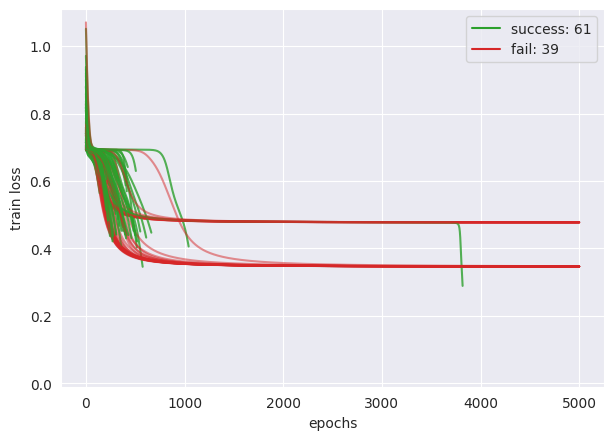

In [25]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='tab:green', label=f"success: {counter[True]}"),
                   Line2D([0], [0], color='tab:red', label=f"fail: {counter[False]}")]


plt.figure(figsize=(7, 5), dpi=100)
for i in history_dict:
    color = 'tab:green' if history_dict[i]['success'] else 'tab:red'
    alpha = 0.8 if history_dict[i]['success'] else 0.5
    plt.plot(history_dict[i]['history_loss'], color=color, alpha=alpha)
plt.legend(handles=legend_elements)
plt.ylim(-0.01)
plt.xlabel('epochs')
plt.ylabel('train loss')
plt.show()

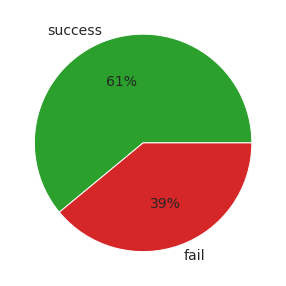

In [26]:
plt.figure(figsize=(5,5))
plt.pie(counter.values(), 
        labels=list(map(lambda x: 'success' if x else 'fail', counter.keys())),
        colors=['tab:green', 'tab:red'],
        autopct='%.0f%%',
        textprops={'fontsize': 14})
plt.show()

In [27]:
stat_mlp = run_df[run_df['success']]['history_len'].describe()
stat_mlp

count      61.000000
mean      384.655738
std       477.590825
min        48.000000
25%       206.000000
50%       309.000000
75%       416.000000
max      3819.000000
Name: history_len, dtype: float64

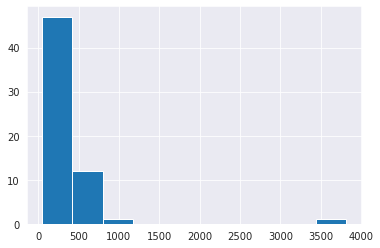

In [28]:
run_df[run_df['success']]['history_len'].hist();

In [29]:
stat = pd.DataFrame(data={'big_model':stat_big, 'mlp':stat_mlp},
                   index = stat_big.index)
stat

,big_model,mlp
count,88.000000,61.000000
mean,335.920455,384.655738
std,308.500013,477.590825
min,108.000000,48.000000
25%,193.000000,206.000000
50%,266.000000,309.000000
75%,335.000000,416.000000
max,2264.000000,3819.000000


# XOR(4)

In [51]:
n = 4
# set_random_seed(23) # just for get a complex random function
# X, y = random_boolfunc(n_inputs=n)
X, y = _xor(n)
display(to_dataframe(X, y))
X, y = torch.Tensor(X), torch.Tensor(y)


,x4,x3,x2,x1,y
0,0,0,0,0,0
1,0,0,0,1,1
2,0,0,1,0,1
3,0,0,1,1,0
4,0,1,0,0,1
5,0,1,0,1,0
6,0,1,1,0,0
7,0,1,1,1,1
8,1,0,0,0,1
9,1,0,0,1,0


In [18]:
neurons = []
current_neuron = Neuron(n_inputs=n, activation=nn.Sigmoid()).to(device)

train(current_neuron, X, y, device=device, epochs=5000, verbose=False)

X_new, y_new = check(current_neuron, X, y, device=device)

if X_new is None:
    result_model = current_neuron
    print(result_model)

else:
    neurons.append(deepcopy(current_neuron))
    
    while X_new is not None:
        
        current_neuron = Neuron(n_inputs=n, activation=nn.Sigmoid()).to(device)

        train(current_neuron, X_new, y_new, device=device, epochs=5000, verbose=False)

        X_new, y_new = check(current_neuron, X_new, y_new, device=device)
        
        neurons.append(deepcopy(current_neuron))
    
    # neurons.append(Neuron(n_inputs=n, activation=nn.ReLU()))
    # neurons.append(Neuron(n_inputs=n))
    
    big_model = BigModel(neurons, activation=nn.Sigmoid()).to(device)
    
    train(big_model, X, y, device=device, epochs=100000, verbose=False)
    
    check(big_model, X, y, device=device)
    
    result_model = deepcopy(big_model)

Neuron gives wrong answers for samples [0, 3, 5, 6, 9, 10, 12, 15]
Success!
BigModel gives wrong answers for samples [7, 11, 13, 14]


In [19]:
check(result_model, X, y, device=device)

BigModel gives wrong answers for samples [7, 11, 13, 14]


(tensor([[0., 1., 1., 1.],
         [1., 0., 1., 1.],
         [1., 1., 0., 1.],
         [1., 1., 1., 0.]]),
 tensor([[1.],
         [1.],
         [1.],
         [1.]]))

In [20]:
result_model

BigModel(
  (base_models): ModuleList(
    (0): Neuron(
      (fc): Linear(in_features=4, out_features=1, bias=True)
      (activation): Sigmoid()
    )
    (1): Neuron(
      (fc): Linear(in_features=4, out_features=1, bias=True)
      (activation): Sigmoid()
    )
  )
  (fc): Linear(in_features=2, out_features=1, bias=True)
  (activation): Sigmoid()
)

In [21]:
result_model(X[15:16])

tensor([[0.3636]], grad_fn=<SigmoidBackward0>)

# Эксперимент 1. XOR(4) vs Algorithm
Учим XOR(4) по алгоритму. З модели, каждая учится 100 раз
* из 2 предобученных нейронов
* 2 предобученных + 1 случайный (экстра-нейрон)
* 2 предобученных + 2 случайных
* 2 предобученных + 3 случайных

Также для сравнения перебираем три формы инициализации: дефолтную, Ксавье-нормальную, Ксавье-равномерную 

In [22]:
def experiment_1(X, y, init_form, num_extra_neurons, num_runs):
    counter = {'success':0, 'fail':0}

    for _ in tqdm(range(num_runs)):

        neurons = []
        current_neuron = Neuron(n_inputs=n, activation=nn.Sigmoid(), init_form=init_form).to(device)

        train(current_neuron, X, y, device=device, epochs=5000, verbose=False)

        X_new, y_new = check(current_neuron, X, y, device=device, verbose=False)

        if X_new is None:
            result_model = current_neuron
            print(result_model)

        else:
            neurons.append(deepcopy(current_neuron))

            while X_new is not None:

                current_neuron = Neuron(n_inputs=n, activation=nn.Sigmoid(), init_form=init_form).to(device)

                train(current_neuron, X_new, y_new, device=device, epochs=5000, verbose=False)

                X_new, y_new = check(current_neuron, X_new, y_new, device=device, verbose=False)

                neurons.append(deepcopy(current_neuron))

            for extra in range(num_extra_neurons):
                neurons.append(Neuron(n_inputs=n, activation=nn.Sigmoid(), init_form=init_form).to(device))

            big_model = BigModel(neurons, activation=nn.Sigmoid(), init_form=init_form).to(device)

            train(big_model, X, y, device=device, epochs=100000, verbose=False)

            check(big_model, X, y, device=device, verbose=False)

            result_model = deepcopy(big_model)

        if check(result_model, X, y, device=device, verbose=False)[0] is None:
            counter['success'] += 1
        else:
            counter['fail'] += 1
        
    return result_model, counter

In [23]:
%%time
results_dict = {'Extra neurons':[0, 1, 2, 3],  
                'None':[],
                'normal':[],
                'uniform':[]}
for init_form in [None, 'normal', 'uniform']:
    print(f'{init_form} init')
    for num_extra_neurons in results_dict['Extra neurons']:
        print(f'    {num_extra_neurons} extra neurons')
        _, counter = experiment_1(X, y, init_form=init_form,
                                  num_extra_neurons=num_extra_neurons, num_runs=100)
        print(f'    {counter}')
        results_dict[str(init_form)].append(counter['success'])

None init
    0 extra neurons


100%|███████████████████████████████████████| 100/100 [1:49:49<00:00, 65.90s/it]


    {'success': 0, 'fail': 100}
    1 extra neurons


100%|███████████████████████████████████████| 100/100 [2:05:59<00:00, 75.59s/it]


    {'success': 39, 'fail': 61}
    2 extra neurons


100%|███████████████████████████████████████| 100/100 [2:22:06<00:00, 85.27s/it]


    {'success': 88, 'fail': 12}
    3 extra neurons


100%|███████████████████████████████████████| 100/100 [2:38:17<00:00, 94.98s/it]


    {'success': 98, 'fail': 2}
normal init
    0 extra neurons


100%|███████████████████████████████████████| 100/100 [1:50:03<00:00, 66.03s/it]


    {'success': 0, 'fail': 100}
    1 extra neurons


100%|███████████████████████████████████████| 100/100 [2:06:06<00:00, 75.66s/it]


    {'success': 55, 'fail': 45}
    2 extra neurons


100%|███████████████████████████████████████| 100/100 [2:22:09<00:00, 85.29s/it]


    {'success': 85, 'fail': 15}
    3 extra neurons


100%|███████████████████████████████████████| 100/100 [2:42:16<00:00, 97.37s/it]


    {'success': 93, 'fail': 7}
uniform init
    0 extra neurons


100%|███████████████████████████████████████| 100/100 [1:53:28<00:00, 68.09s/it]


    {'success': 0, 'fail': 100}
    1 extra neurons


100%|███████████████████████████████████████| 100/100 [2:06:35<00:00, 75.95s/it]


    {'success': 52, 'fail': 48}
    2 extra neurons


100%|███████████████████████████████████████| 100/100 [2:23:09<00:00, 85.90s/it]


    {'success': 85, 'fail': 15}
    3 extra neurons


100%|███████████████████████████████████████| 100/100 [2:37:54<00:00, 94.74s/it]

    {'success': 88, 'fail': 12}
CPU times: user 1d 2h 57min 53s, sys: 756 ms, total: 1d 2h 57min 54s
Wall time: 1d 2h 57min 56s


# Результаты, выводы

In [24]:
pd.DataFrame(results_dict)

,Extra neurons,None,normal,uniform
0,0,0,0,0
1,1,39,55,52
2,2,88,85,85
3,3,98,93,88


* Добавление всего одного экстра-нейрона, инициализированного со случайными весами, позволяет сети учиться. 
* Чем больше добавляем экстра-нейронов, тем более вероятно обучение завершится успехом.
* При одном экстра-нейроне Ксавье-инициализация, что нормальная, что равномерная, повышает вероятность успешно обучиться. Но при большем числе экстра-нейронов, как будто снижает, если это можно считать статистически значимым, либо как минимум не повышает.
* Тем не менее, думаю пока можно принять решение использовать **нормальную Ксавье-инициализацию**.

# Эксперимент 2. Дают ли буст предобученные нейроны, или все дело только в архитектуре?
Учим большую модель из 3 случайных нейронов и модель с 2 предобученными и 1 экстра

## Большая модель из 3 случайных скрытых нейронов

In [22]:
neurons = [Neuron(n_inputs=n, activation=nn.Sigmoid()) for _ in range(3)]

big_model = BigModel(neurons, activation=nn.Sigmoid()).to(device)

train(big_model, X, y, device=device, epochs=100000, verbose=True)

check(big_model, X, y, device=device)

result_model = deepcopy(big_model)

epoch 10000: loss 0.00
epoch 20000: loss 0.00
epoch 30000: loss 0.00
epoch 40000: loss 0.00
epoch 50000: loss 0.00
epoch 60000: loss 0.00
epoch 70000: loss 0.00
epoch 80000: loss 0.00
epoch 90000: loss 0.00
epoch 100000: loss 0.00
Success!


# Попытка 10 раз обучить модель с 3 случайными нейронами

In [26]:
counter_3_random = {'success':0, 'fail':0}

for _ in range(10):

    #     !!!
    neurons = [Neuron(n_inputs=n, activation=nn.Sigmoid()) for _ in range(3)]

    big_model = BigModel(neurons, activation=nn.Sigmoid()).to(device)

    train(big_model, X, y, device=device, epochs=2000, verbose=True)

    X_new, y_new = check(big_model, X, y, device=device)

    result_model = deepcopy(big_model)
    
    if X_new is None:
        counter_3_random['success'] += 1
    else:
        counter_3_random['fail'] += 1

print(counter_3_random)

epoch 200: loss 0.65
epoch 400: loss 0.23
epoch 600: loss 0.08
epoch 800: loss 0.04
epoch 1000: loss 0.02
epoch 1200: loss 0.02
epoch 1400: loss 0.01
epoch 1600: loss 0.01
epoch 1800: loss 0.01
epoch 2000: loss 0.01
Success!
epoch 200: loss 0.63
epoch 400: loss 0.20
epoch 600: loss 0.08
epoch 800: loss 0.05
epoch 1000: loss 0.03
epoch 1200: loss 0.02
epoch 1400: loss 0.02
epoch 1600: loss 0.01
epoch 1800: loss 0.01
epoch 2000: loss 0.01
Success!
epoch 200: loss 0.53
epoch 400: loss 0.14
epoch 600: loss 0.06
epoch 800: loss 0.04
epoch 1000: loss 0.03
epoch 1200: loss 0.02
epoch 1400: loss 0.01
epoch 1600: loss 0.01
epoch 1800: loss 0.01
epoch 2000: loss 0.01
Success!
epoch 200: loss 0.51
epoch 400: loss 0.14
epoch 600: loss 0.06
epoch 800: loss 0.04
epoch 1000: loss 0.03
epoch 1200: loss 0.02
epoch 1400: loss 0.01
epoch 1600: loss 0.01
epoch 1800: loss 0.01
epoch 2000: loss 0.01
Success!
epoch 200: loss 0.62
epoch 400: loss 0.23
epoch 600: loss 0.10
epoch 800: loss 0.06
epoch 1000: loss

In [27]:
counter_3_random_bad = {'success':0, 'fail':0}

for _ in range(10):

    #     !!!
    neurons = [Neuron(n_inputs=n, activation=nn.Sigmoid())] * 3

    big_model = BigModel(neurons, activation=nn.Sigmoid()).to(device)

    train(big_model, X, y, device=device, epochs=2000, verbose=True)

    X_new, y_new = check(big_model, X, y, device=device)

    result_model = deepcopy(big_model)
    
    if X_new is None:
        counter_3_random_bad['success'] += 1
    else:
        counter_3_random_bad['fail'] += 1

print(counter_3_random_bad)

epoch 200: loss 0.69
epoch 400: loss 0.69
epoch 600: loss 0.69
epoch 800: loss 0.53
epoch 1000: loss 0.49
epoch 1200: loss 0.49
epoch 1400: loss 0.48
epoch 1600: loss 0.48
epoch 1800: loss 0.48
epoch 2000: loss 0.48
BigModel gives wrong answers for samples [1]
epoch 200: loss 0.56
epoch 400: loss 0.50
epoch 600: loss 0.49
epoch 800: loss 0.49
epoch 1000: loss 0.48
epoch 1200: loss 0.48
epoch 1400: loss 0.48
epoch 1600: loss 0.48
epoch 1800: loss 0.48
epoch 2000: loss 0.48
BigModel gives wrong answers for samples [1]
epoch 200: loss 0.55
epoch 400: loss 0.50
epoch 600: loss 0.49
epoch 800: loss 0.48
epoch 1000: loss 0.48
epoch 1200: loss 0.48
epoch 1400: loss 0.48
epoch 1600: loss 0.48
epoch 1800: loss 0.48
epoch 2000: loss 0.48
BigModel gives wrong answers for samples [2]
epoch 200: loss 0.69
epoch 400: loss 0.51
epoch 600: loss 0.49
epoch 800: loss 0.48
epoch 1000: loss 0.48
epoch 1200: loss 0.48
epoch 1400: loss 0.48
epoch 1600: loss 0.48
epoch 1800: loss 0.48
epoch 2000: loss 0.48
B

In [34]:
print(id(result_model.base_models[0]))
print(id(result_model.base_models[1]))
print(id(result_model.base_models[2]))
print(result_model.base_models[0].fc.weight)
print(result_model.base_models[1].fc.weight)
print(result_model.base_models[2].fc.weight)
print(result_model.fc.weight)

1995343191688
1995343191688
1995343191688
Parameter containing:
tensor([[ 9.0889, -8.3191]], requires_grad=True)
Parameter containing:
tensor([[ 9.0889, -8.3191]], requires_grad=True)
Parameter containing:
tensor([[ 9.0889, -8.3191]], requires_grad=True)
Parameter containing:
tensor([[-2.3849, -2.3189, -3.2634]], requires_grad=True)


In [36]:
counter = {'success':0, 'fail':0}

for _ in range(10):

    neurons = []
    current_neuron = Neuron(n_inputs=n, activation=nn.Sigmoid()).to(device)

    train(current_neuron, X, y, device=device, epochs=5000, verbose=False)

    X_new, y_new = check(current_neuron, X, y, device=device, verbose=False)

    if X_new is None:
        result_model = current_neuron
        print(result_model)

    else:
        neurons.append(deepcopy(current_neuron))

        while X_new is not None:

            current_neuron = Neuron(n_inputs=n, activation=nn.Sigmoid()).to(device)

            train(current_neuron, X_new, y_new, device=device, epochs=5000, verbose=False)

            X_new, y_new = check(current_neuron, X_new, y_new, device=device, verbose=False)

            neurons.append(deepcopy(current_neuron))

        for extra in range(1):
            neurons.append(Neuron(n_inputs=n, activation=nn.Sigmoid()).to(device))

        big_model = BigModel(neurons, activation=nn.Sigmoid()).to(device)

        train(big_model, X, y, device=device, epochs=2000, verbose=True)

        X_new, y_new = check(big_model, X, y, device=device, verbose=False)

        result_model = deepcopy(big_model)

    if X_new is None:
        counter['success'] += 1
    else:
        counter['fail'] += 1

print(counter)

epoch 200: loss 0.67
epoch 400: loss 0.27
epoch 600: loss 0.07
epoch 800: loss 0.04
epoch 1000: loss 0.02
epoch 1200: loss 0.02
epoch 1400: loss 0.01
epoch 1600: loss 0.01
epoch 1800: loss 0.01
epoch 2000: loss 0.01
epoch 200: loss 0.54
epoch 400: loss 0.38
epoch 600: loss 0.36
epoch 800: loss 0.35
epoch 1000: loss 0.35
epoch 1200: loss 0.35
epoch 1400: loss 0.35
epoch 1600: loss 0.35
epoch 1800: loss 0.35
epoch 2000: loss 0.35
epoch 200: loss 0.56
epoch 400: loss 0.37
epoch 600: loss 0.36
epoch 800: loss 0.35
epoch 1000: loss 0.35
epoch 1200: loss 0.35
epoch 1400: loss 0.35
epoch 1600: loss 0.35
epoch 1800: loss 0.35
epoch 2000: loss 0.35
epoch 200: loss 0.68
epoch 400: loss 0.33
epoch 600: loss 0.14
epoch 800: loss 0.07
epoch 1000: loss 0.04
epoch 1200: loss 0.03
epoch 1400: loss 0.02
epoch 1600: loss 0.02
epoch 1800: loss 0.01
epoch 2000: loss 0.01
epoch 200: loss 0.56
epoch 400: loss 0.11
epoch 600: loss 0.05
epoch 800: loss 0.03
epoch 1000: loss 0.02
epoch 1200: loss 0.01
epoch 14

## Результаты, выводы
Была ошибка в инициализации большой модели из 3-х случайных нейронов: код 

` neurons = [Neuron(n_inputs=n, activation=nn.Sigmoid())] * 3`

`big_model = BigModel(neurons, activation=nn.Sigmoid()).to(device)`

задает модель из трех нейронов, которые *были ссылками на один и тот же объект*. В `neurons` было 3 нейрона, но это было 3 копии одного объекта. И тогда модель не училась (0 успехов из 10 запусков).

Если делать правильно 

` neurons = [Neuron(n_inputs=n, activation=nn.Sigmoid()) for _ in range(3)]`

То это будет 3 честных случайных независимых нейрона. В таком случае модель учится в 9 случаев из 10.

А вот использование 2-х предобученных, и дополнительного одного случайного, в тех же условиях обучения, приводит лишь к 5 успешным обучениям из 10.

В итоге можно сделать вывод, что обучение с нуля даже лучше, а использование двух предобученных нейронов в совокупности с экстра случайным, только мешает.

:( :( :(